# CS6482 Assignment 2: DQN for Atari (DemonAttack)

## Submission Structure
This notebook follows the prescribed format:
1. **Why RL?** (2 marks)
2. **The Environment** (1 mark)
3. **Vanilla DQN Implementation** (6 marks)
4. **Results & Evaluation: Vanilla DQN** (4 marks)
5. **Double DQN Implementation** (4 marks)
6. **Results & Evaluation: Double DQN** (3 marks)
7. **Comparison: DQN vs Double DQN** (3 marks)
8. **Added Value** (4 marks)
9. **References** (Pass/Fail)

# Student Name and ID: Arinze Obidiegwu 23271892
# Code runs to completion without error

# Introduction and Background

In this notebook, I implement a Deep Q-Network (DQN) agent to play the Atari game **DemonAttack** using the Arcade Learning Environment (ALE) provided by Gymnasium.

**About DemonAttack:**  
DemonAttack is a classic Atari game set on the icy planet of Krybor, where you face successive waves of demonic enemies. The goal is to earn points by eliminating demons. You begin with three reserve bunkers; these bunkers can increase (up to a maximum of six) if you avoid enemy attacks. Each uninterrupted wave earns you an extra bunker, while each hit causes you to lose one. The game ends when a hit occurs and no bunkers remain.

For additional details, you can review the official documentation on [AtariAge](https://atariage.com/manual_html_page.php?SoftwareLabelID=135) and visit the [ALE DemonAttack Environment Page](https://ale.farama.org/environments/demon_attack/).

**Environment Specifications:**  
- **Action Space:** The environment has a discrete action space with 6 actions:
  - **0:** NOOP  
  - **1:** FIRE  
  - **2:** RIGHT  
  - **3:** LEFT  
  - **4:** RIGHTFIRE  
  - **5:** LEFTFIRE
- **Observation Space:**  
  The default observation is provided as an RGB image with dimensions **(210, 160, 3)** and pixel values in the range 0 to 255.
- **Variants:**  
  In this assignment, we are using the `ALE/DemonAttack-v5` variant, which employs:
  - `obs_type="rgb"`
  - A fixed frameskip of 4
  - A repeat action probability of 0.25

## 1. **Why Use Reinforcement Learning?**  
Reinforcement Learning (RL) is ideally suited for this kind of task because it allows an agent to learn optimal policies through direct interaction with the environment. Unlike supervised methods, RL does not require labeled data but instead uses rewards from sequential decision-making processes. This quality makes it particularly effective for dynamic and complex tasks like playing Atari games.

## 2. The Environment

**a. Atari game selected:** ALE/DemonAttack-v5  
**b. Inputs:** RGB frames (210×160×3), float rewards, done/truncated flags  
**c. Controls:** Discrete actions {0–5}, frame-skip=4, repeat_action_prob=0.25

In [1]:
import os
import random
import pickle
import numpy as np
import cv2
import torch
import ale_py
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import deque
from tqdm.notebook import trange
from gymnasium.wrappers import RecordVideo
from gymnasium.wrappers import FrameStackObservation as FrameStack

In [2]:
# after your import block
import torch
torch.set_num_threads(8)
torch.set_num_interop_threads(8)

In [3]:
# Device  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
print(f"Using device: {device}")

Using device: cpu


In [4]:
# Directory map (ensure these folders exist or will be created)  
dirs = {  
    'videos_vanilla': 'videos/vanilla',  
    'videos_double':  'videos/double',  
    'checkpoints':    'checkpoints'  
} 

for p in dirs.values():  
    os.makedirs(p, exist_ok=True)

In [5]:
# Environment name & shapes  
env_name        = 'ALE/DemonAttack-v5'  
input_shape     = (84, 84)  

# Training hyperparameters  
gamma           = 0.99  
buffer_capacity = 100000  
batch_size      = 32  
num_episodes    = 500  
target_update_freq = 10  

# Epsilon‐greedy schedule  
epsilon_start   = 1.0  
epsilon_end     = 0.1  
epsilon_decay   = 1000000    # linear decay over episodes  
lr = 5e-5
target_update_freq = 1000        # by steps

In [6]:
def save_checkpoint(ckpt_path, buf_path, episode, net, target_net, optimizer,
                    rewards, losses, epsilon, replay_buffer):
    torch.save({
        'episode':          episode,
        'model_state':      net.state_dict(),
        'target_state':     target_net.state_dict(),
        'optimizer_state':  optimizer.state_dict(),
        'epsilon':          epsilon,
        'rewards_history':  rewards,
        'loss_history':     losses
    }, ckpt_path)
    with open(buf_path, 'wb') as f:
        pickle.dump(replay_buffer, f)

def load_checkpoint(ckpt_path, buf_path, net, target_net, optimizer, device):
    ckpt = torch.load(ckpt_path, map_location=device)
    net.load_state_dict(ckpt['model_state'])
    target_net.load_state_dict(ckpt['target_state'])
    optimizer.load_state_dict(ckpt['optimizer_state'])
    next_ep  = ckpt['episode'] + 1
    rewards  = ckpt['rewards_history']
    losses   = ckpt['loss_history']
    epsilon  = ckpt['epsilon']
    with open(buf_path, 'rb') as f:
        replay_buffer = pickle.load(f)
    return next_ep, rewards, losses, epsilon, replay_buffer

Observation shape: (210, 160, 3)


A.L.E: Arcade Learning Environment (version 0.10.2+c9d4b19)
[Powered by Stella]


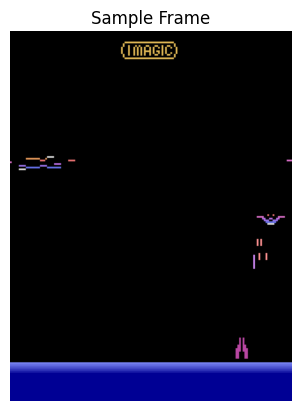

In [7]:
env = gym.make('ALE/DemonAttack-v5', render_mode='rgb_array')
obs, _ = env.reset()
print('Observation shape:', obs.shape)
plt.imshow(obs); plt.title('Sample Frame'); plt.axis('off')
env.close()

## 3. Vanilla DQN Implementation

### 3a. Data Capture & Preprocessing

Preprocessed shape: (84, 84)


(-0.5, 83.5, 83.5, -0.5)

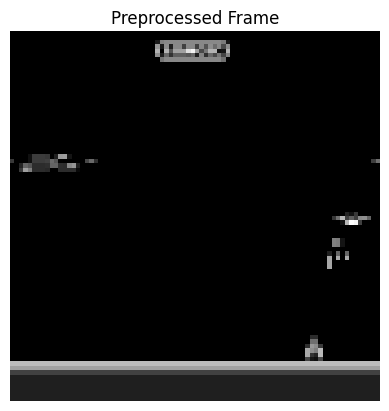

In [8]:
# We convert each RGB frame to grayscale, resize to 84×84, and normalize to [0,1] to reduce input dimensionality while preserving key spatial features.
def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)
    return resized.astype(np.float32) / 255.0

# Verify
sample = preprocess_frame(obs)
print('Preprocessed shape:', sample.shape)
plt.imshow(sample, cmap='gray'); plt.title('Preprocessed Frame'); plt.axis('off')

### 3b. Network Structure

In [9]:
# The DQN network has three convolutional layers (8×8@32,stride4; 4×4@64,stride2; 3×3@64,stride1) followed by a 512-unit fully connected layer and output layer for Q-values over 6 actions (Mnih et al., 2015).
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1,32,8,4), nn.ReLU(),
            nn.Conv2d(32,64,4,2), nn.ReLU(),
            nn.Conv2d(64,64,3,1), nn.ReLU()
        )
        dummy = torch.zeros(1,1,*input_shape)
        n_flat = int(np.prod(self.conv(dummy).shape))
        self.fc = nn.Sequential(
            nn.Linear(n_flat,512), nn.ReLU(),
            nn.Linear(512,num_actions)
        )
    def forward(self,x):
        x = self.conv(x)
        return self.fc(x.view(x.size(0),-1))

print(DQN((84,84),6))

DQN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)


### 3c. Q-Learning Update

We implement the standard DQN loss:  

using experience replay and separate target network updates every fixed interval.


In [10]:
def compute_dqn_loss(batch, online, target, gamma, device):
    states, actions, rewards, next_states, dones = zip(*batch)
    s   = torch.from_numpy(np.stack(states)).unsqueeze(1).float().to(device)
    ns  = torch.from_numpy(np.stack(next_states)).unsqueeze(1).float().to(device)
    a   = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(device)
    r   = torch.tensor(rewards, dtype=torch.float32).to(device)      # <— force float32
    d   = torch.tensor(dones,   dtype=torch.float32).to(device)

    q_values = online(s).gather(1, a).squeeze()
    with torch.no_grad():
        max_next = target(ns).max(1)[0]
    target_q = r + gamma * max_next * (1 - d)
    return F.mse_loss(q_values, target_q)

In [11]:
def compute_double_dqn_loss(batch, online, target, gamma, device):
    states, actions, rewards, next_states, dones = zip(*batch)
    s   = torch.from_numpy(np.stack(states)).unsqueeze(1).float().to(device)
    ns  = torch.from_numpy(np.stack(next_states)).unsqueeze(1).float().to(device)
    a   = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(device)
    r   = torch.tensor(rewards, dtype=torch.float32).to(device)      # <— force float32
    d   = torch.tensor(dones,   dtype=torch.float32).to(device)

    q_values     = online(s).gather(1, a).squeeze()
    with torch.no_grad():
        best_actions = online(ns).argmax(dim=1, keepdim=True)
        next_q       = target(ns).gather(1, best_actions).squeeze()
    target_q     = r + gamma * next_q * (1 - d)
    return F.mse_loss(q_values, target_q)

In [12]:
class ReplayBuffer:
    def __init__(self, cap): self.buf = deque(maxlen=cap)
    def push(self, *t): self.buf.append(t)
    def sample(self,b): return random.sample(self.buf,b)
    def __len__(self): return len(self.buf)

## 4. Results & Evaluation for Vanilla DQN
- **Plots**: Episode rewards and loss curves
- **Evaluation**: We evaluate learning by increasing cumulative reward and decreasing loss.
- **Is the agent learning?** Yes if average reward trends upward.



In [13]:
# --- Vanilla DQN Training with step‑based ε‑decay ---
van_rewards, van_losses = [], []
total_steps = 0

# Paths
van_ckpt = os.path.join(dirs['checkpoints'], 'vanilla_dqn.ckpt')
van_buf  = os.path.join(dirs['checkpoints'], 'memory_vanilla.pkl')

# Env + video + frame‑stacking
env_v = gym.make(env_name, render_mode='rgb_array')
env_v = RecordVideo(env_v, dirs['videos_vanilla'], episode_trigger=lambda ep: ep % 10 == 0)
env_v = FrameStack(env_v, 4)

# Networks & optimizer
online_v = DQN(input_shape, env_v.action_space.n).to(device)
target_v = DQN(input_shape, env_v.action_space.n).to(device)
target_v.load_state_dict(online_v.state_dict())
opt_v    = optim.Adam(online_v.parameters(), lr=5e-5)

# Replay buffer
replay_v = ReplayBuffer(buffer_capacity)

# Restore checkpoint if available
if os.path.exists(van_ckpt) and os.path.exists(van_buf):
    start_ep, van_rewards, van_losses, eps_v, replay_v = load_checkpoint(
        van_ckpt, van_buf, online_v, target_v, opt_v, device)
    print(f"Resuming Vanilla DQN from ep {start_ep}, ε={eps_v:.3f}")
else:
    start_ep, eps_v = 0, epsilon_start

# Training loop
for ep in trange(start_ep, num_episodes, desc="Vanilla DQN"):
    obs, _ = env_v.reset()
    # obs shape: (4,84,84); take the most recent frame for preprocessing
    state   = preprocess_frame(obs[-1])
    total_r = 0
    done    = False

    while not done:
        total_steps += 1
        # step‑based epsilon decay
        eps_v = epsilon_end + (epsilon_start - epsilon_end) * \
                max(0, (epsilon_decay - total_steps)) / epsilon_decay

        # select action
        if random.random() < eps_v:
            action = env_v.action_space.sample()
        else:
            t = torch.from_numpy(state).unsqueeze(0).unsqueeze(0).to(device)
            action = online_v(t).argmax().item()

        # step env
        nxt, reward, term, trunc, _ = env_v.step(action)
        reward = np.sign(reward)            # reward clipping
        done   = term or trunc
        nxt_state = preprocess_frame(nxt[-1])

        # store transition
        replay_v.push(state, action, reward, nxt_state, done)
        state, total_r = nxt_state, total_r + reward

        # learning step
        if len(replay_v) >= batch_size:
            batch = replay_v.sample(batch_size)
            loss  = compute_dqn_loss(batch, online_v, target_v, gamma, device)
            opt_v.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(online_v.parameters(), 10)
            opt_v.step()
            van_losses.append(loss.item())

        # step‑based target update
        if total_steps % target_update_freq == 0:
            target_v.load_state_dict(online_v.state_dict())

    # end of episode bookkeeping
    van_rewards.append(total_r)

    # checkpoint + video
    if ep % 10 == 0 or ep == num_episodes - 1:
        save_checkpoint(van_ckpt, van_buf, ep, online_v, target_v,
                        opt_v, van_rewards, van_losses, eps_v, replay_v)

        # print summary
        avg10 = np.mean(van_rewards[-10:]) if len(van_rewards) >= 10 else np.nan
        print(f"[Vanilla] Ep {ep:3d} | Reward: {van_rewards[-1]:6.1f} | "
              f"Avg₁₀: {avg10:6.1f} | ε={eps_v:.3f}")

/Users/caephas/Downloads/School-Projects/ReinforcementLearning/.venv/lib/python3.11/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/caephas/Downloads/School-Projects/ReinforcementLearning/videos/vanilla folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Vanilla DQN:   0%|          | 0/500 [00:00<?, ?it/s]

[Vanilla] Ep   0 | Reward:   13.0 | Avg₁₀:    nan | ε=0.999
[Vanilla] Ep  10 | Reward:    9.0 | Avg₁₀:   13.7 | ε=0.992
[Vanilla] Ep  20 | Reward:   17.0 | Avg₁₀:   16.7 | ε=0.980
[Vanilla] Ep  30 | Reward:    7.0 | Avg₁₀:   11.7 | ε=0.974
[Vanilla] Ep  40 | Reward:   16.0 | Avg₁₀:   11.2 | ε=0.967
[Vanilla] Ep  50 | Reward:   24.0 | Avg₁₀:   15.1 | ε=0.959
[Vanilla] Ep  60 | Reward:   30.0 | Avg₁₀:   15.7 | ε=0.950
[Vanilla] Ep  70 | Reward:   19.0 | Avg₁₀:   16.5 | ε=0.940
[Vanilla] Ep  80 | Reward:   18.0 | Avg₁₀:   16.9 | ε=0.929
[Vanilla] Ep  90 | Reward:   55.0 | Avg₁₀:   18.0 | ε=0.920
[Vanilla] Ep 100 | Reward:   11.0 | Avg₁₀:   14.9 | ε=0.912
[Vanilla] Ep 110 | Reward:   21.0 | Avg₁₀:   18.8 | ε=0.901
[Vanilla] Ep 120 | Reward:   12.0 | Avg₁₀:   15.1 | ε=0.894
[Vanilla] Ep 130 | Reward:   14.0 | Avg₁₀:   14.2 | ε=0.884
[Vanilla] Ep 140 | Reward:   18.0 | Avg₁₀:   17.4 | ε=0.875
[Vanilla] Ep 150 | Reward:   22.0 | Avg₁₀:   19.7 | ε=0.865
[Vanilla] Ep 160 | Reward:   11.0 | Avg₁

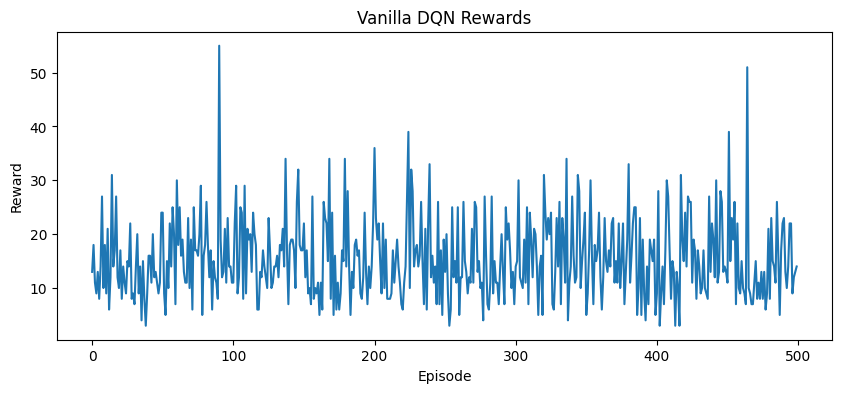

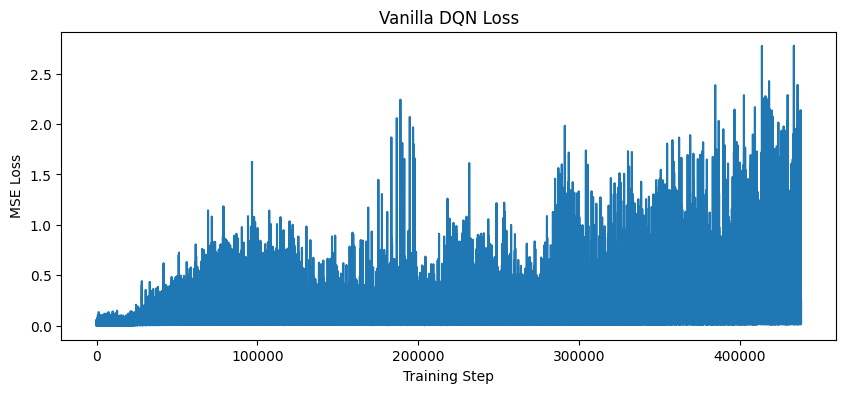

In [14]:

## Plot Vanilla DQN Results

plt.figure(figsize=(10,4))
plt.plot(van_rewards)
plt.title('Vanilla DQN Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(van_losses)
plt.title('Vanilla DQN Loss')
plt.xlabel('Training Step')
plt.ylabel('MSE Loss')
plt.show()

## 5. Double DQN Implementation

### 5a. Problem Addressed 
Standard DQN overestimates action values because the same network selects and evaluates actions, leading to suboptimal policies (Van Hasselt et al., 2016).

### 5b. Theoretical Solution
Double DQN uses the target
$$
Q_{\text{target}}(s,a) = r + \gamma \, Q_{\text{target}}\bigl(s', \arg\max_{a'} Q_{\text{online}}(s',a')\bigr),
$$
decoupling action selection (by the online network) from evaluation (by the target network) to reduce the overestimation bias of standard DQN.

## 6. Results & Evaluation for Double DQN

In [15]:
# --- Double DQN Training with step‑based ε‑decay ---
db_rewards, db_losses = [], []
total_steps = 0

# Paths
dbl_ckpt = os.path.join(dirs['checkpoints'], 'double_dqn.ckpt')
dbl_buf  = os.path.join(dirs['checkpoints'], 'memory_double.pkl')

# Env + video + frame‑stacking
env_d = gym.make(env_name, render_mode='rgb_array')
env_d = RecordVideo(env_d, dirs['videos_double'], episode_trigger=lambda ep: ep % 10 == 0)
env_d = FrameStack(env_d, 4)

# Networks & optimizer
online_d = DQN(input_shape, env_d.action_space.n).to(device)
target_d = DQN(input_shape, env_d.action_space.n).to(device)
target_d.load_state_dict(online_d.state_dict())
opt_d    = optim.Adam(online_d.parameters(), lr=5e-5)

# Replay buffer
replay_d = ReplayBuffer(buffer_capacity)

# Restore checkpoint if available
if os.path.exists(dbl_ckpt) and os.path.exists(dbl_buf):
    start_ep2, db_rewards, db_losses, eps_d, replay_d = load_checkpoint(
        dbl_ckpt, dbl_buf, online_d, target_d, opt_d, device)
    print(f"Resuming Double DQN from ep {start_ep2}, ε={eps_d:.3f}")
else:
    start_ep2, eps_d = 0, epsilon_start

# Training loop
for ep in trange(start_ep2, num_episodes, desc="Double DQN"):
    obs, _ = env_d.reset()
    state   = preprocess_frame(obs[-1])
    total_r = 0
    done    = False

    while not done:
        total_steps += 1
        # step‑based epsilon decay
        eps_d = epsilon_end + (epsilon_start - epsilon_end) * \
                max(0, (epsilon_decay - total_steps)) / epsilon_decay

        # select action
        if random.random() < eps_d:
            action = env_d.action_space.sample()
        else:
            t = torch.from_numpy(state).unsqueeze(0).unsqueeze(0).to(device)
            action = online_d(t).argmax().item()

        # step env
        nxt, reward, term, trunc, _ = env_d.step(action)
        reward = np.sign(reward)            # reward clipping
        done   = term or trunc
        nxt_state = preprocess_frame(nxt[-1])

        # store transition
        replay_d.push(state, action, reward, nxt_state, done)
        state, total_r = nxt_state, total_r + reward

        # learning step
        if len(replay_d) >= batch_size:
            batch = replay_d.sample(batch_size)
            loss  = compute_double_dqn_loss(batch, online_d, target_d, gamma, device)
            opt_d.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(online_d.parameters(), 10)
            opt_d.step()
            db_losses.append(loss.item())

        # step‑based target update
        if total_steps % target_update_freq == 0:
            target_d.load_state_dict(online_d.state_dict())

    # end of episode bookkeeping
    db_rewards.append(total_r)

    # checkpoint + video
    if ep % 10 == 0 or ep == num_episodes - 1:
        save_checkpoint(dbl_ckpt, dbl_buf, ep, online_d, target_d,
                        opt_d, db_rewards, db_losses, eps_d, replay_d)

        # print summary
        avg10_d = np.mean(db_rewards[-10:]) if len(db_rewards) >= 10 else np.nan
        print(f"[Double] Ep {ep:3d} | Reward: {db_rewards[-1]:6.1f} | "
              f"Avg₁₀: {avg10_d:6.1f} | ε={eps_d:.3f}")

/Users/caephas/Downloads/School-Projects/ReinforcementLearning/.venv/lib/python3.11/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/caephas/Downloads/School-Projects/ReinforcementLearning/videos/double folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Double DQN:   0%|          | 0/500 [00:00<?, ?it/s]

[Double] Ep   0 | Reward:    7.0 | Avg₁₀:    nan | ε=1.000
[Double] Ep  10 | Reward:   17.0 | Avg₁₀:   15.1 | ε=0.990
[Double] Ep  20 | Reward:   16.0 | Avg₁₀:   14.6 | ε=0.981
[Double] Ep  30 | Reward:   20.0 | Avg₁₀:   15.7 | ε=0.972
[Double] Ep  40 | Reward:   10.0 | Avg₁₀:   14.4 | ε=0.964
[Double] Ep  50 | Reward:   16.0 | Avg₁₀:   12.6 | ε=0.958
[Double] Ep  60 | Reward:    7.0 | Avg₁₀:   15.5 | ε=0.949
[Double] Ep  70 | Reward:    5.0 | Avg₁₀:   13.7 | ε=0.942
[Double] Ep  80 | Reward:    9.0 | Avg₁₀:   12.0 | ε=0.935
[Double] Ep  90 | Reward:    5.0 | Avg₁₀:   13.0 | ε=0.928
[Double] Ep 100 | Reward:   14.0 | Avg₁₀:   13.1 | ε=0.920
[Double] Ep 110 | Reward:   20.0 | Avg₁₀:   18.1 | ε=0.911
[Double] Ep 120 | Reward:   25.0 | Avg₁₀:   16.2 | ε=0.902
[Double] Ep 130 | Reward:   10.0 | Avg₁₀:   15.9 | ε=0.894
[Double] Ep 140 | Reward:   10.0 | Avg₁₀:   14.6 | ε=0.886
[Double] Ep 150 | Reward:   20.0 | Avg₁₀:   18.8 | ε=0.876
[Double] Ep 160 | Reward:    9.0 | Avg₁₀:   18.0 | ε=0.8

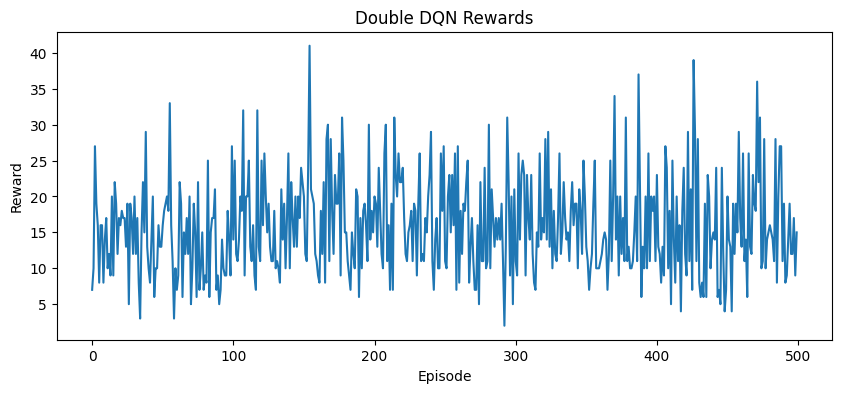

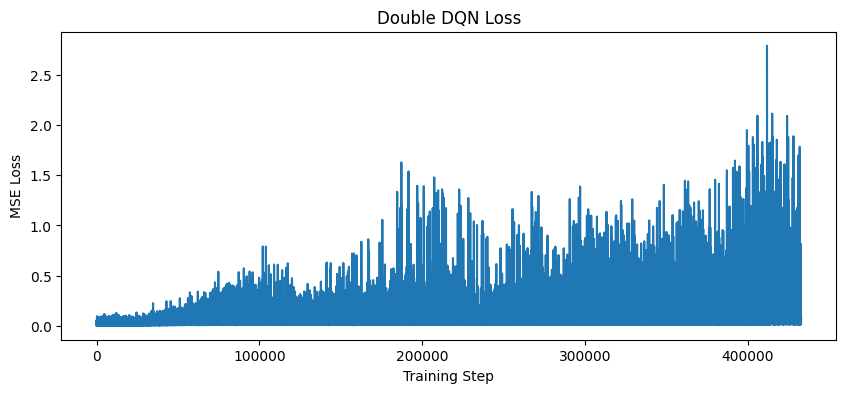

In [16]:
## Plot Double DQN Results

plt.figure(figsize=(10,4))
plt.plot(db_rewards)
plt.title('Double DQN Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()
plt.figure(figsize=(10,4))
plt.plot(db_losses)
plt.title('Double DQN Loss')
plt.xlabel('Training Step')
plt.ylabel('MSE Loss')
plt.show()

## 7. Comparison of DQN vs Double DQN

## 8. Added Value

### 8a. Hyperparameter Insights

### 8b. Prioritized Experience Replay

### 8c. Literature Discussion

## 9. References (P/F)
1. Sutton, R. S., & Barto, A. G. (2018). *Reinforcement Learning: An Introduction*.  
2. Mnih, V. et al. (2015). *Human-level control through deep reinforcement learning*. Nature.  
3. Van Hasselt, H., Guez, A., & Silver, D. (2016). *Deep Reinforcement Learning with Double Q-learning*. AAAI.  
4. Schaul, T. et al. (2015). *Prioritized Experience Replay*. ICLR.  
5. Hessel, M. et al. (2018). *Rainbow: Combining Improvements in Deep Reinforcement Learning*. AAAI.
